# Title

# Abstract

# Table of contents <a name="TOC"></a>
1. [Introduction](#intro)
2. [Data aquisition](#data-aquisition)
3. [Data exploration](#data-exploration)

# Introduction <a name="intro"></a>

[Go back to the top](#TOC)

# Data acquisition <a name="data-aquisition"></a>

[Go back to the top](#TOC)

The data we analyse are given by the NTDS course. They can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/TerrorAttack.tgz).

In [1]:
# utility imports
import pandas as pd
import numpy as np
from collections import Counter
import scipy.sparse.linalg
from scipy.spatial.distance import pdist, squareform
from scipy import sparse, stats, spatial

# ml imports
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing, decomposition
from sklearn.cluster import KMeans

# visualization imports
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/home/painguin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
PATH = "TerrorAttack/"
SEED = 0

In [3]:
# Load data
edges_org = pd.read_csv(PATH +'terrorist_attack_loc_org.edges', sep=' ', header=None)
edges = pd.read_csv(PATH +'terrorist_attack_loc.edges', sep=' ', header=None)
labels = pd.read_csv(PATH +'terrorist_attack.labels', sep=' ', header=None)
nodes = pd.read_csv(PATH +'terrorist_attack.nodes', sep='\t', header=None)
n_nodes = nodes.shape[0]

# Data exploration and cleaning <a name="data-exploration"></a>

[Go back to the top](#TOC)

In [4]:
nodes.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
1,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
2,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
3,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
4,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...


In [5]:
nodes[0][42]

'http://counterterror.mindswap.org/2005/ict_events.owl#Unknown_19980110'

The nodes are identified by an internet link. However, there is information given inside the link: the name of the organization after `#` in the link and the date of the attack and the end of the link.  
  
We will extract these information and construct a new data frame.

In [6]:
# extract information of date and organization from the link
nodes_info = nodes[0].apply(lambda x : (x.split("#"))[1])
dates = nodes_info.apply(lambda x : x[-8:])
dates = pd.to_datetime(dates, format='%Y%m%d', errors='coerce')
organizations = nodes_info.apply(lambda x : x[:-9])

attacks_dict = {"organization": organizations, "date": dates}
attacks = pd.DataFrame(attacks_dict)

attacks.head()

,organization,date
0,United_Popular_Action_Movement,1993-05-13
1,Unknown,1996-11-12
2,Unknown,1998-04-28
3,Kurdistan_Worker_s_Party,1997-03-25
4,Unknown,1999-03-14


We observe that there are some unknown organizations. We want to know the number of the unknown values.

In [7]:
attacks.organization.value_counts().head()

Unknown                      519
Hamas                         99
Fatah_Tanzim                  52
Palestinian_Islamic_Jihad     50
                              48
Name: organization, dtype: int64

That is pretty much. We may predict the organization who is responsible of an attack for those unknown author. First, we check the proportion of attacks that are created by known organizations which create at least 10 attacks. In fact, if an organization only have few rows in the `nodes` dataset, it will be difficult to extract information from the limited rows.

In [8]:
ATK_THRESHOLD = 10

In [9]:
attacks.organization.replace('', 'Unknown', inplace=True)

In [10]:
attack_per_org = attacks.organization.value_counts()[1:]
num_attacks = attack_per_org.sum()
prop_freq_org = attack_per_org[attack_per_org >= ATK_THRESHOLD].sum() / num_attacks

print("There are {:.2%} of known attacks are created by frequent organizations.".format(prop_freq_org))

There are 80.30% of known attacks are created by frequent organizations.


Which seems good for us to predict.

In [11]:
# concatenate features into the dataframe of attacks
attacks = pd.concat([attacks, nodes.iloc[:, 1:]], axis=1)

# get only the type of attack from last column
attacks.iloc[:, -1] = nodes.iloc[:, -1].apply(lambda x: x.split('#')[1])

attacks.head()

,organization,date,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,United_Popular_Action_Movement,1993-05-13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arson
1,Unknown,1996-11-12,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Arson
2,Unknown,1998-04-28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arson
3,Kurdistan_Worker_s_Party,1997-03-25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arson
4,Unknown,1999-03-14,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Arson


We will now also have a look on the number of attacks w.r.t time. 

In [12]:
dates = attacks.date.dropna()

In [13]:
attack_year = dates.apply(lambda d: d.year)
year_min = attack_year.min()
year_max = attack_year.max()

print("Our data contains attacks start from year {} till {}"
      .format(year_min, year_max))

Our data contains attacks start from year 1969 till 2002


/home/painguin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


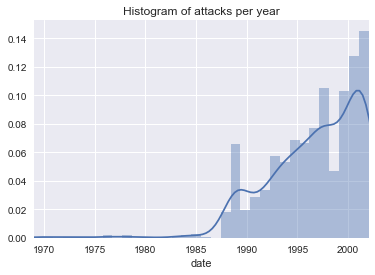

In [14]:
sns.distplot(attack_year, bins=year_max - year_min + 1)
plt.title('Histogram of attacks per year')
plt.xlim([year_min, year_max]);

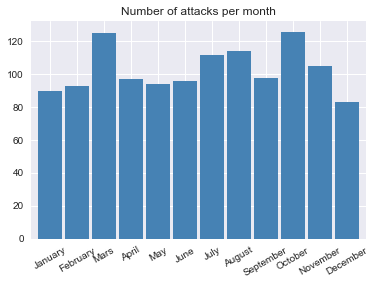

In [15]:
attack_month = dates.apply(lambda d: d.month)
month_occurences = attack_month.value_counts().sort_index()
month_occurences.index = ['January', 'February', 'Mars', 'April', 'May', 'June',
                          'July', 'August', 'September', 'October', 'November', 'December']

month_occurences.plot.bar(width=0.9, color='steelblue', title='Number of attacks per month', rot=30);

#### Check similarity within organization

To see if it is relevant to try to predict the organizations based on the features, we check if the feature distance between attacks of the same organization are smaller than across organizations.

In [16]:
#Transform the labels into features with dummy variable encoding, also dismiss the labels
features = pd.get_dummies(nodes.iloc[:, 1:])

In [17]:
dot_products = features@features.T
norms = np.sqrt(np.diag(dot_products))
sim_matrix = dot_products / np.outer(norms, norms)

In [18]:
diffs = []

for i in range(n_nodes):
    org = attacks['organization'][i]
    sim = sim_matrix[i]
    if org != 'Unknown' and attack_per_org[org] >= 10:
        org_indices = attacks[attacks.organization == org].index
        diffs += [sim[org_indices].mean() - sim.mean()]

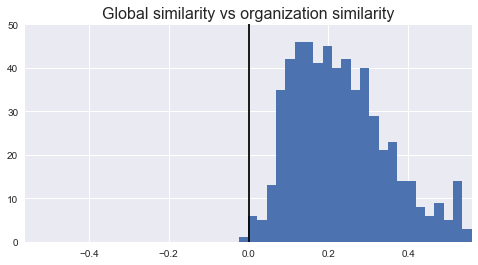

In [19]:
fig = plt.figure(figsize=(8,4))
plt.hist(diffs, bins=25)
plt.xlim(-max(diffs), max(diffs))
plt.ylim((0, 50))
plt.vlines(0, 0, 50)
plt.title('Global similarity vs organization similarity', size=16);

## Building a feature graph

In [20]:
#creating the adjacency matrix for our feature graph

#pdist computes the pairwise euclidean distance
distances = pdist(features)
kernel_width = distances.mean()

#Gaussian function
weights = np.exp(-distances**2 / kernel_width**2)
features_adjacency = squareform(weights)

In [21]:
# put the diagonal values to 0
features_adjacency[(range(n_nodes), range(n_nodes))] = 0

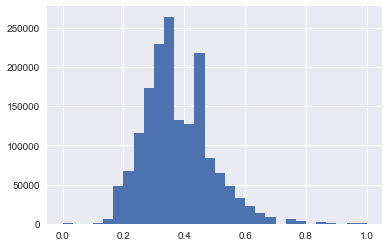

In [22]:
plt.hist(features_adjacency.ravel(), bins=30);

In [23]:
# sparsify the matrix for visualization
sparse_f_adjacency = features_adjacency.copy()
sparse_f_adjacency[sparse_f_adjacency < 0.7] = 0 

In [24]:
sparse_graph = nx.from_numpy_array(sparse_f_adjacency)

Save the graph to use it in gephi

In [25]:
nx.write_gexf(sparse_graph, 'feature_graph.gexf')

# Finding organisations reponsible of an attack

Our goal is to see if we can predict who is behind an attack based only on the data we have. For the first 2 approach, we are only going to use the attacks where the terrorist organization is known, and we also sub-sample the data to keep only the top 3 organizations with the most attacks because it will be easier to see.

In [26]:
# only select organizations with enough attacks
famous_orgs = attack_per_org[attack_per_org >= ATK_THRESHOLD].index

# create a mapping between the organizations and labels
idx_to_org = pd.Series(famous_orgs, name='organization')
org_to_idx = idx_to_org.reset_index().set_index('organization')['index']

# organizations with more than ATK_THRESHOLD attacks 
X = features[attacks.organization.apply(lambda org: org in famous_orgs)]
y = attacks.query('organization in @famous_orgs').organization.apply(lambda x: org_to_idx[x])

# top 3 organizations
top3_orgs = attack_per_org.index[:3]
top3_orgs_idx = attacks.query('organization in @top3_orgs').index
X_top3 = X.loc[top3_orgs_idx]
y_top3 = y[top3_orgs_idx]

## Using PCA and K-Means

Here, we will use Principle Component Analysis to reduce our feature graph from a very high dimension (113) to a 2 dimensional space. This lets us embbed it in a graph.

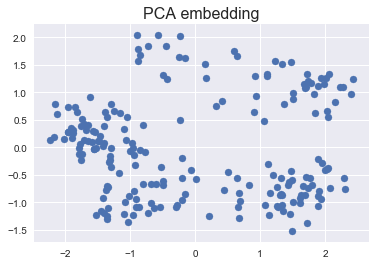

In [27]:
features_pca = decomposition.PCA(n_components=2).fit_transform(X_top3)
plt.scatter(features_pca[:, 0], features_pca[:, 1]);
plt.title('PCA embedding', size=16);

Now we run K-Means to compute 3 clusters:

In [28]:
H = features_pca
clusters3 = KMeans(n_clusters=3, random_state=0).fit_predict(H)

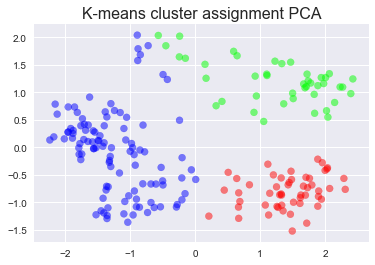

In [29]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters3, cmap='brg', alpha=0.5);
plt.title('K-means cluster assignment PCA', size=16);

Now we need to compare these clusters with the actual truth labels

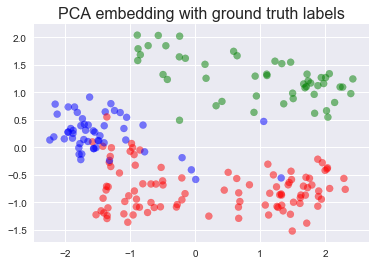

In [30]:
color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[n] for n in y_top3]
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=colors, cmap='brg', alpha=0.5);
plt.title('PCA embedding with ground truth labels', size=16);

We can compute the accuracy of our prediction (in percent)

In [31]:
translate = {0:1, 1:0, 2:2}
labels = np.vectorize(translate.get)(y_top3)
((labels == clusters3).sum() / labels.shape[0])*100

71.14427860696517

71 percent! This is not that bad, but let's see if we can do better with spectral embedding

## Using Spectral Embedding and K-Means

We restrict our feature adjacency to the top 3 organizations and build the normalized laplacian out of it

In [32]:
f_adj_top3 = features_adjacency[top3_orgs_idx][:, top3_orgs_idx]
degrees_top3 = f_adj_top3.sum(axis=0)

# Combinatorial Laplacian.
laplacian = np.diag(degrees_top3) - f_adj_top3
# Normalized Laplacian.
deg_inv = np.diag(1 / np.sqrt(degrees_top3))
laplacian = deg_inv @ laplacian @ deg_inv
laplacian = sparse.csr_matrix(laplacian)


Now we compute the eigenvalue decompostion to be able to embbed it in 2D.

In [33]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=3, which='SM')

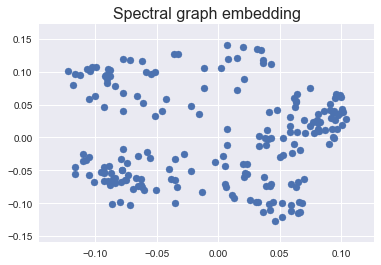

In [34]:
sortID = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sortID]
eigenvectors = eigenvectors[:,sortID]
proj  = eigenvectors[:,1:3]
plt.scatter(proj[:,0],proj[:,1])
plt.title('Spectral graph embedding', size=16);

Again, we run K-means on it

In [35]:
H = eigenvectors[:,1:3]; 
spect_kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(H)

#to match the number of the cluster with the number of the true label
spect_kmeans = (spect_kmeans + 1) % 3

Cluster that k-means gives us:

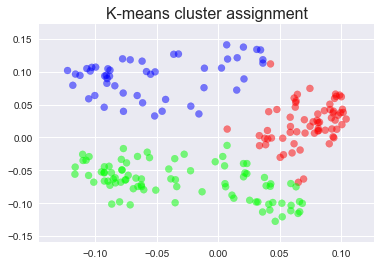

In [36]:
plt.scatter(proj[:,0],proj[:,1], c=spect_kmeans, cmap='brg', alpha=0.5)
    
plt.title('K-means cluster assignment', size=16);

In [37]:
# For k=3
new_order3 = np.array([],dtype = int)
for i in range(3):
    new_order3 = np.append(new_order3,np.where(clusters3 == i))

Now we compare it with our real labels:

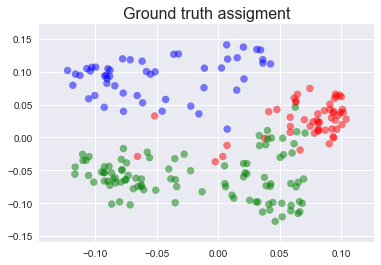

In [38]:
color_map = {0: 'green', 1: 'red', 2: 'blue'}
colors = [color_map[n] for n in y_top3]
plt.scatter(proj[:,0],proj[:,1], c=colors, cmap='brg', alpha=0.5)
plt.title('Ground truth assigment', size=16);

And we compute the accuracy:

In [39]:
translate = {0:2, 1:1, 2:0}
labels = np.vectorize(translate.get)(y_top3)
((labels == spect_kmeans).sum() / labels.shape[0])*100

88.55721393034825

Our accuracy this time is 88%.

## Using Linear Support Vector Classification.

#### Cross-validation

In [40]:
correct = Counter()
total = Counter()

for train_idx, test_idx in KFold(X.shape[0], 4, shuffle=True, random_state=SEED):
    # split the data
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    # fit the model
    model = OneVsRestClassifier(LinearSVC(random_state=SEED))
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    for i in range(len(y_pred)):
        y_p = y_pred[i]
        y_t = y_test.iloc[i]

        total[y_t] += 1
        if y_p == y_t:
            correct[y_t] += 1

In [41]:
prediction_comparision = pd.DataFrame([correct, total]).T.fillna(0)
prediction_comparision.columns = ['correct', 'total']
prediction_comparision.index = famous_orgs

In [42]:
correctly_predicted = prediction_comparision.correct.sum()
print('With %d correct predictions from a total of %d samples, we obtain a success rate of %.3f%%!'
      % (correctly_predicted, y.shape[0], 100 * correctly_predicted / y.shape[0]))

With 532 correct predictions from a total of 583 samples, we obtain a success rate of 91.252%!


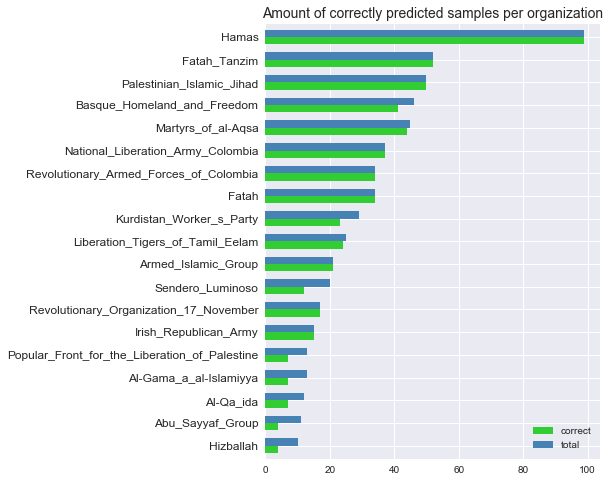

In [43]:
prediction_comparision.sort_values('total').plot.barh(figsize=(6, 8), color=['limegreen', 'steelblue'], width=0.65, alpha=1)
plt.yticks(size=12)
plt.title('Amount of correctly predicted samples per organization', size=14);

For most of the top 19 organizations, the predictions we obtain are very accurate! We observe however that our model has more trouble predicting organizations with few attacks because of the consequently small amount of training data for the organization.

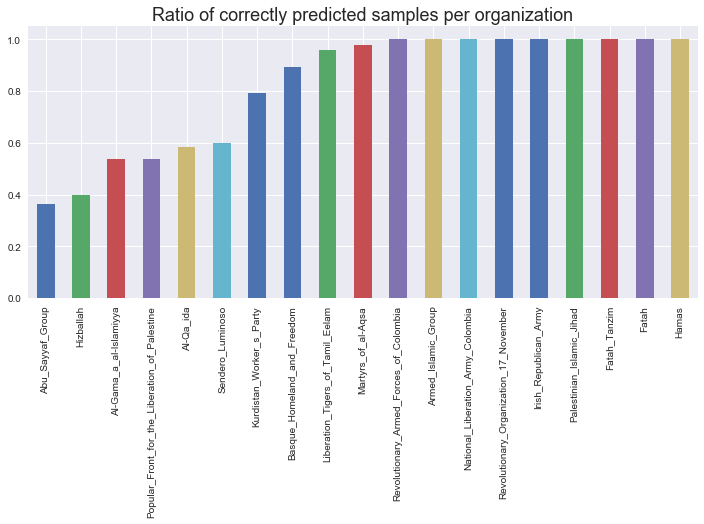

In [44]:
(prediction_comparision.correct / prediction_comparision.total).sort_values().plot.bar(figsize=(12,5))
plt.title('Ratio of correctly predicted samples per organization', size= 18);

#### Predict the unknown organizations

In [45]:
X_unknown = features[attacks.organization.apply(lambda x: x == 'Unknown')]

model = OneVsRestClassifier(LinearSVC(random_state=SEED))
model.fit(X, y)

# predict
y_pred = model.predict(X_unknown)
y_pred_orgs = idx_to_org[y_pred]

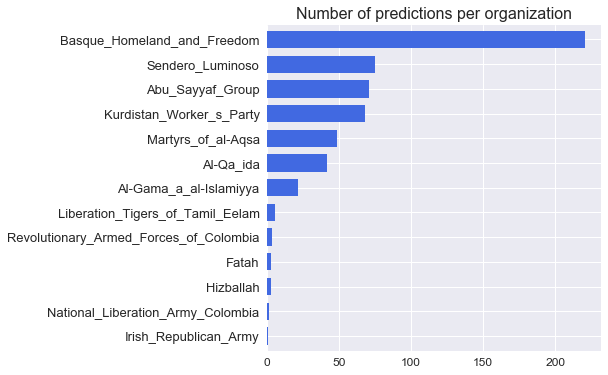

In [46]:
y_pred_orgs.value_counts().iloc[::-1].plot.barh(figsize=(6, 6), color='royalblue', width=0.7)
plt.title('Number of predictions per organization', size=16)
plt.yticks(size=13)
plt.xticks(size=12);